In [43]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import re

In [44]:
labels = ['nolipsstick','lipstick']

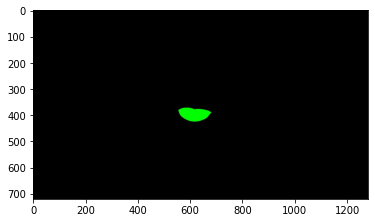

In [45]:
some_image = plt.imread('set-lipstick-original/mask/mask00000003.png')
plt.imshow(some_image)

In [47]:
len(set(list(some_image.flatten())))

225

(3, 720, 1280)
(720, 1280, 3)


7745.0

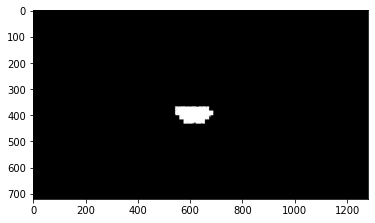

In [50]:
a = some_image.sum(axis=-1)
a = np.array([a,a,a])
print(a.shape)
a = a.transpose(1,2,0)
print(a.shape)
a = np.where(a == 0, a, 1)
plt.imshow(a)
a.shape

a[:,:,1].sum()

У нас 214 цветов используется. надо сделать все одним.

In [51]:
lips_images = []
lips_segmentation = []

for root, dirs, files in os.walk('set-lipstick-original'):
    for name in files:
        f = os.path.join(root, name)
        if 'photos' in f:
            lips_images.append(f)
        elif 'mask' in f:
            lips_segmentation.append(f)
        else:
            break

In [52]:
len(lips_images), len(lips_segmentation)

(28594, 28539)

У нас разное количество картинок. нужно избавиться от лишних. Находим пересечение множеств названий картинок, и оставляем только 
те которые есть в обоих папках.

In [53]:

valid_photos = set([re.search(r'\d+', i)[0] for i in lips_images])
valid_masks = set([re.search(r'\d+', i)[0] for i in lips_segmentation])
intersection = valid_photos.intersection(valid_masks)

lips_images = [i for i in lips_images if re.search(r'\d+', i)[0] in intersection]
lips_segmentation = [i for i in lips_segmentation if re.search(r'\d+', i)[0] in intersection]

In [54]:
len(lips_images), len(lips_segmentation)

(28539, 28539)

In [55]:
num_of_images = 1000
df = pd.DataFrame({'lips_images': sorted(lips_images)[:num_of_images], 'lips_segmentation': sorted(lips_segmentation)[:num_of_images]})
# Отсортируем  датафрейм по значениям
df.sort_values(by='lips_images',inplace=True)
# Используем функцию,
# лагодаря которой индексация значений 
# будет начинаться с 0.
df.reset_index(drop=True, inplace=True)
# Выведем первые ять значений нашего датафрейма
df.head(5)

,lips_images,lips_segmentation
0,set-lipstick-original\photos\image00000001.jpg,set-lipstick-original\mask\mask00000001.png
1,set-lipstick-original\photos\image00000002.jpg,set-lipstick-original\mask\mask00000002.png
2,set-lipstick-original\photos\image00000003.jpg,set-lipstick-original\mask\mask00000003.png
3,set-lipstick-original\photos\image00000004.jpg,set-lipstick-original\mask\mask00000004.png
4,set-lipstick-original\photos\image00000005.jpg,set-lipstick-original\mask\mask00000005.png


In [56]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F

In [57]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
        
        # convert str names to class values on masks
        # Конвертируем стринговые имена в значения класса на маске
        self.class_values = [labels.index(cls) for cls in labels]
        
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        img = Image.open(self.image_arr[index])
        # Преобразовываем к размеру 256х256
        img = img.resize((256,256))
        img = np.asarray(img).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # Количество каналов ставим на первый план - этого хочет pytorch
        img = img.permute(2,0,1).float()
        
        # Считываем нашу маску
        mask = np.asarray(plt.imread(self.label_arr[index]))

        if mask.ndim != 3:
            print(self.label_arr[index])
        mask = np.asarray(plt.imread(self.label_arr[index])).sum(axis=-1)

        mask = np.where(mask == 0, mask, 1)

        # Здесь мы создаем список бинарных масок из нашей одной общей маски 
        masks = [(mask == v) for v in self.class_values]
        # Стекаем все вместе в один многомерный тензор масок
        mask = np.stack(masks, axis=-1).astype('float')
        #  Приводим к типу тензора
        mask = torch.as_tensor(mask)
        # Размерность каналов на передний план
        mask = mask.permute(2,0,1)
        
        # делаем ресайз маски на 256х256
        # Для этого используем функцию interpolate
        ### Что бы ресайзить и высоту и ширину картинки, нужно перед interpolate
        ### пороизвести unsqueeze над тензором, и squeeze после.
        # unsqueeze - меняет размерность img c (256, 256, 3) -> (1, 256, 256, 3),
        mask = mask.unsqueeze(0)
        mask = F.interpolate(input=mask, size=256, mode='nearest')
        mask=mask.squeeze(0).squeeze(0)
        
        
        return (img, mask)

    def __len__(self):
        return self.data_len

In [58]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.2)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [59]:
train_data_loader = DataLoader(train_data,batch_size=8,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=8,shuffle=True)

In [60]:
sample = iter(train_data_loader).next()

In [61]:
sample[0].size()

torch.Size([8, 3, 256, 256])

In [62]:
sample[1].size()

torch.Size([8, 2, 256, 256])

In [63]:
np.unique(sample[1])

array([0., 1.])

In [64]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [65]:
import segmentation_models_pytorch as smp
import time

# создание модели

segmodel = smp.Linknet(
    'resnet34',
    encoder_weights='imagenet',
    classes=2,
    activation='softmax'
    ).to(device)

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=segmodel.parameters(), lr=0.0001),
])

train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

max_score = 0



In [66]:
for i in range(0, 5):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_smp_model.pth')
        print('Model saved!')
        
    if i == 3:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\zald\AppData\Roaming\Python\Python39\site-packages\segmentation_models_pytorch\base\modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


valid: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s, dice_loss - 0.1525, iou_score - 0.9828]
Model saved!

Epoch: 1
valid: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s, dice_loss - 0.08499, iou_score - 0.9947]
Model saved!

Epoch: 2
valid: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s, dice_loss - 0.05021, iou_score - 0.9962]
Model saved!
Decrease decoder learning rate to 1e-5!

Epoch: 4
valid: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s, dice_loss - 0.04893, iou_score - 0.9963]
Model saved!


In [67]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [68]:
best_model = torch.load('./best_smp_model.pth')

In [69]:
def get_orig(image):
    #image = images[0,:,:,:]
    image = image.permute(1, 2, 0)
    image = image.numpy()
    image = np.clip(image, 0, 1)
    return image

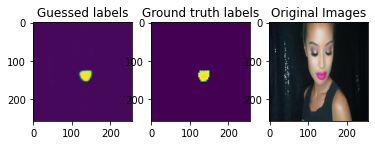

<ipython-input-70-a1e6f4f81877>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.gcf().show()


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

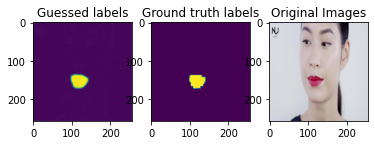

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

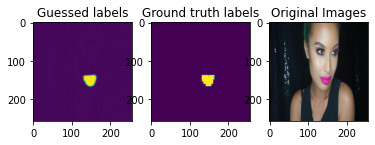

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

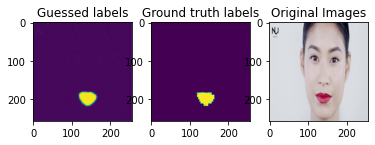

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

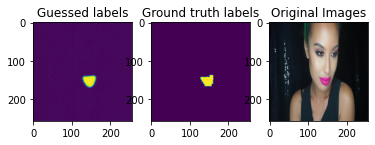

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

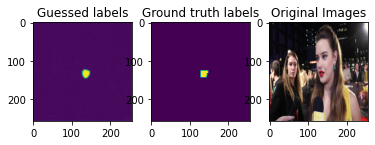

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

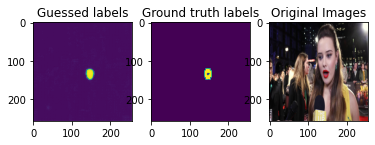

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [70]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = segmodel(images)
    f, axarr = plt.subplots(1,3)

    for j in range(0,4):
        axarr[0].imshow(outputs.squeeze().detach().cpu().numpy()[j,1,:,:])
        axarr[0].set_title('Guessed labels')

        axarr[1].imshow(labels.detach().cpu().numpy()[j,1,:,:])
        axarr[1].set_title('Ground truth labels')

        original = get_orig(images[j].cpu())
        axarr[2].imshow(original)
        axarr[2].set_title('Original Images')
        plt.show()
        plt.gcf().show()
    if i>5:
        break